<a href="https://colab.research.google.com/github/lqdungx/TTNT/blob/main/DemoTTNT_CGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# CHƯƠNG 4: ỨNG DỤNG GAN TRONG BÀI TOÁN TẠO ẢNH CHỮ SỐ

# 4.1. PHÁT BIỂU BÀI TOÁN VÀ PHƯƠNG PHÁP TIẾP CẬN
# Mục tiêu: Sinh ảnh chữ số theo nhãn cho trước sử dụng Conditional GAN (CGAN)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


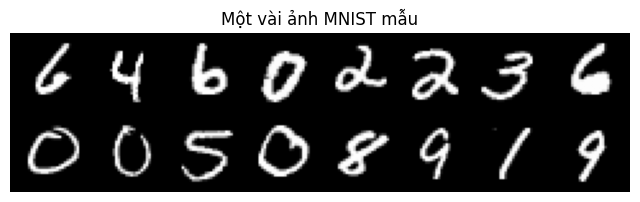

In [10]:
# 4.2.1. Giới thiệu bộ dữ liệu MNIST
# MNIST gồm 60,000 ảnh train và 10,000 ảnh test của các chữ số 0-9, kích thước 28x28

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Hiển thị vài ảnh mẫu
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(8, 4))
plt.axis('off')
plt.title("Một vài ảnh MNIST mẫu")
plt.imshow(make_grid(images[:16], nrow=8, normalize=True).permute(1, 2, 0))
plt.show()


In [11]:
# Lớp kiến trúc Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=1)
        return self.model(x)


In [12]:
# Lớp kiến trúc Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat((img, labels), dim=1)
        return self.model(x)


In [33]:
#Tham số huấn luyện và quá trình học
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_dim = 28*28
noise_dim = 100
label_dim = 10

G = Generator(noise_dim, label_dim, img_dim).to(device)
D = Discriminator(img_dim, label_dim).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

epochs = 100
print("Bắt đầu huấn luyện...")

for epoch in range(epochs):
    for real_imgs, labels in train_loader:
        real_imgs = real_imgs.view(-1, 28*28).to(device)
        batch_size = real_imgs.size(0)

        # one-hot nhãn
        real_labels = torch.eye(label_dim)[labels].to(device)

        # sinh nhiễu và nhãn ngẫu nhiên
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_labels = torch.randint(0, label_dim, (batch_size,))
        fake_onehot = torch.eye(label_dim)[fake_labels].to(device)

        fake_imgs = G(noise, fake_onehot)

        # ---- Huấn luyện Discriminator ----
        D_real = D(real_imgs, real_labels)
        D_fake = D(fake_imgs.detach(), fake_onehot)

        loss_D = criterion(D_real, torch.ones_like(D_real)) + \
                 criterion(D_fake, torch.zeros_like(D_fake))

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ---- Huấn luyện Generator ----
        D_fake = D(fake_imgs, fake_onehot)
        loss_G = criterion(D_fake, torch.ones_like(D_fake))

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")


Bắt đầu huấn luyện...
Epoch [1/100]  Loss_D: 0.0552  Loss_G: 6.1920
Epoch [2/100]  Loss_D: 0.1469  Loss_G: 4.5276
Epoch [3/100]  Loss_D: 0.2957  Loss_G: 3.7842
Epoch [4/100]  Loss_D: 0.6714  Loss_G: 2.8926
Epoch [5/100]  Loss_D: 0.0557  Loss_G: 4.4270
Epoch [6/100]  Loss_D: 0.0752  Loss_G: 4.4465
Epoch [7/100]  Loss_D: 0.1272  Loss_G: 4.7941
Epoch [8/100]  Loss_D: 0.0679  Loss_G: 7.8539
Epoch [9/100]  Loss_D: 0.1541  Loss_G: 7.4008
Epoch [10/100]  Loss_D: 0.2750  Loss_G: 4.8559
Epoch [11/100]  Loss_D: 0.0883  Loss_G: 5.7947
Epoch [12/100]  Loss_D: 0.0771  Loss_G: 8.0000
Epoch [13/100]  Loss_D: 0.0967  Loss_G: 6.1246
Epoch [14/100]  Loss_D: 0.2246  Loss_G: 5.6118
Epoch [15/100]  Loss_D: 0.2872  Loss_G: 5.1037
Epoch [16/100]  Loss_D: 0.2880  Loss_G: 4.9026
Epoch [17/100]  Loss_D: 0.3389  Loss_G: 4.3931
Epoch [18/100]  Loss_D: 0.1461  Loss_G: 5.8319
Epoch [19/100]  Loss_D: 0.2039  Loss_G: 4.7727
Epoch [20/100]  Loss_D: 0.1437  Loss_G: 5.1583
Epoch [21/100]  Loss_D: 0.2282  Loss_G: 5.2549


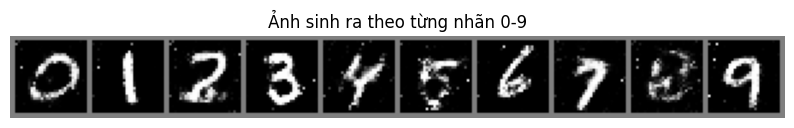

In [34]:
# 4.4.1. Đánh giá định tính – Ảnh sinh ra
G.eval()
with torch.no_grad():
    noise = torch.randn(10, noise_dim).to(device)
    labels = torch.arange(0, 10)
    onehot = torch.eye(label_dim)[labels].to(device)
    fake_imgs = G(noise, onehot).view(-1, 1, 28, 28)

plt.figure(figsize=(10, 2))
plt.axis('off')
plt.title("Ảnh sinh ra theo từng nhãn 0-9")

# Dòng hiển thị ảnh mới, ảnh sẽ sáng và rõ nét hơn
plt.imshow(make_grid(fake_imgs.cpu(), nrow=10).permute(1,2,0) * 0.5 + 0.5)
plt.show()


In [15]:
!pip install torchmetrics torch-fidelity


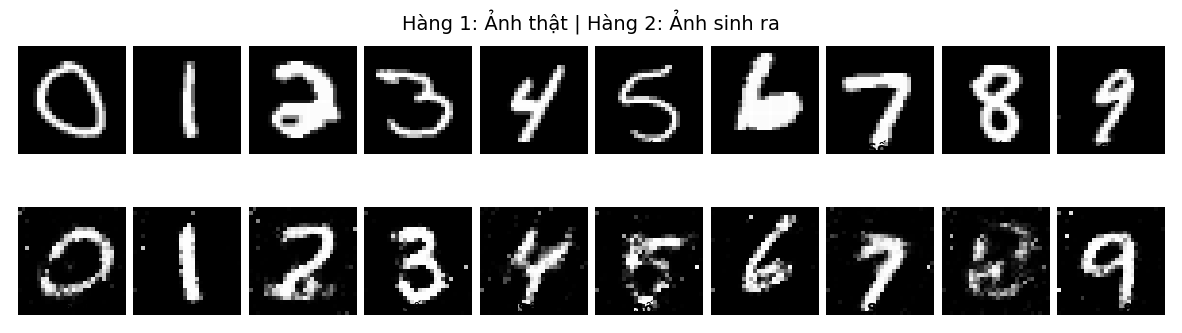

In [36]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Giả sử bạn đã có ảnh sinh ra trước đó trong biến fake_imgs
# và nhãn tương ứng là labels = torch.arange(0,10)

# -------------------------------
# Lấy ảnh thật MNIST theo nhãn 0->9
# -------------------------------
real_imgs_list = []
real_labels_list = []

for i in range(10):
    for imgs, labels in train_loader:
        mask = labels == i
        if mask.any():
            real_imgs_list.append(imgs[mask][0])
            real_labels_list.append(i)
            break

real_imgs = torch.stack(real_imgs_list).to(device)
real_labels = torch.tensor(real_labels_list).to(device)

# -------------------------------
# Hiển thị song song 2 hàng
# -------------------------------
def show_real_vs_existing_fake(real_imgs, fake_imgs, labels, nrow=10, label_offset=5):
    import numpy as np
    real_imgs = real_imgs.detach().cpu()
    fake_imgs = fake_imgs.detach().cpu()
    labels = labels.detach().cpu().numpy()

    real_grid = make_grid(real_imgs, nrow=nrow, normalize=True, pad_value=1)
    fake_grid = make_grid(fake_imgs, nrow=nrow, normalize=True, pad_value=1)

    pad = 10  # khoảng cách giữa 2 hàng
    combined = np.ones((real_grid.shape[1]*2 + pad, real_grid.shape[2], 3))
    combined[:real_grid.shape[1], :, :] = real_grid.permute(1,2,0).numpy()
    combined[real_grid.shape[1]+pad:, :, :] = fake_grid.permute(1,2,0).numpy()

    fig, ax = plt.subplots(figsize=(15,4))
    ax.imshow(combined)
    ax.axis("off")
    ax.set_title("Hàng 1: Ảnh thật | Hàng 2: Ảnh sinh ra", fontsize=14)

    img_w = real_imgs.shape[3]
    img_h = real_imgs.shape[2]
    x_scale = combined.shape[1] / (nrow * img_w)
    y_scale = combined.shape[0] / (2*img_h + pad)

    for i, label in enumerate(labels):
        col = i % nrow
        # Hàng thật
        x_real = col * img_w * x_scale + img_w*x_scale/2
        y_real = img_h * y_scale - label_offset
        ax.text(x_real, y_real, f"Số {label}", color="black",
                fontsize=10, fontweight="bold", ha="center", va="top")
        # Hàng ảnh giả
        x_fake = col * img_w * x_scale + img_w*x_scale/2
        y_fake = img_h * y_scale * 2 + pad - label_offset
        ax.text(x_fake, y_fake, f"Số {label}", color="black",
                fontsize=10, fontweight="bold", ha="center", va="top")
    plt.show()

# Gọi hàm
show_real_vs_existing_fake(real_imgs, fake_imgs, torch.arange(0,10), nrow=10)


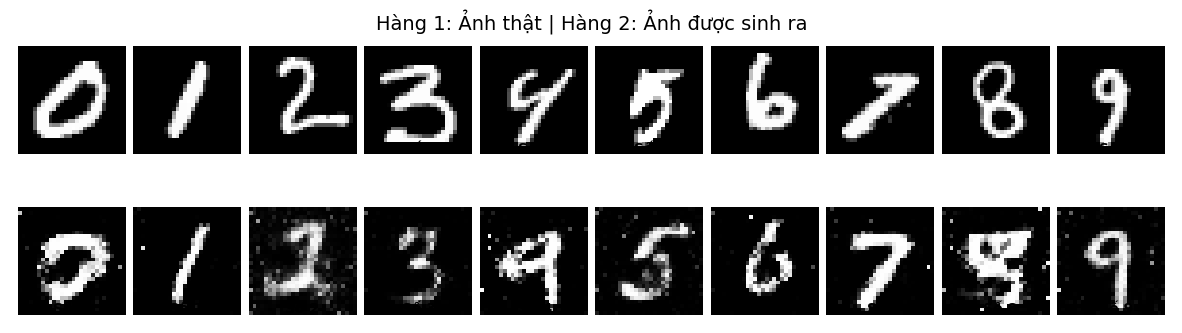

FID: 0.2810
Inception Score: 2.1268 ± 0.2225


In [39]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Chức năng chuyển ảnh về uint8 [0-255]
# -------------------------------
def to_uint8(imgs):
    imgs = (imgs.clamp(-1,1) + 1) / 2.0  # [-1,1] -> [0,1]
    imgs = (imgs * 255).to(torch.uint8)
    return imgs

# -------------------------------
# Hiển thị 2 hàng ảnh thật – ảnh giả kèm nhãn
# -------------------------------
def show_real_fake(real_imgs, fake_imgs, labels, nrow=10, label_offset=5):
    real_imgs = real_imgs.detach().cpu()
    fake_imgs = fake_imgs.detach().cpu()
    labels = labels.detach().cpu().numpy()

    real_grid = make_grid(real_imgs, nrow=nrow, normalize=True, pad_value=1)
    fake_grid = make_grid(fake_imgs, nrow=nrow, normalize=True, pad_value=1)

    pad = 10  # khoảng cách giữa 2 hàng
    combined = np.ones((real_grid.shape[1]*2 + pad, real_grid.shape[2], 3))
    combined[:real_grid.shape[1], :, :] = real_grid.permute(1,2,0).numpy()
    combined[real_grid.shape[1]+pad:, :, :] = fake_grid.permute(1,2,0).numpy()

    fig, ax = plt.subplots(figsize=(15,4))
    ax.imshow(combined)
    ax.axis("off")
    ax.set_title("Hàng 1: Ảnh thật | Hàng 2: Ảnh được sinh ra", fontsize=14)

    img_w = real_imgs.shape[3]
    img_h = real_imgs.shape[2]
    x_scale = combined.shape[1] / (nrow * img_w)
    y_scale = combined.shape[0] / (2*img_h + pad)

    for i, label in enumerate(labels):
        col = i % nrow
        # Hàng thật
        x_real = col * img_w * x_scale + img_w*x_scale/2
        y_real = img_h * y_scale - label_offset
        ax.text(x_real, y_real, f"Số {label}", color="black",
                fontsize=10, fontweight="bold", ha="center", va="top")
        # Hàng ảnh giả
        x_fake = col * img_w * x_scale + img_w*x_scale/2
        y_fake = img_h * y_scale * 2 + pad - label_offset
        ax.text(x_fake, y_fake, f"Số {label}", color="black",
                fontsize=10, fontweight="bold", ha="center", va="top")
    plt.show()

# -------------------------------
# Lấy 10 ảnh thật MNIST đủ nhãn 0-9
# -------------------------------
real_imgs_list = []
real_labels_list = []
for i in range(10):
    for imgs, labels in train_loader:
        mask = labels == i
        if mask.any():
            real_imgs_list.append(imgs[mask][0])
            real_labels_list.append(i)
            break

real_imgs = torch.stack(real_imgs_list).to(device)
real_labels = torch.tensor(real_labels_list).to(device)

# -------------------------------
# Sinh 10 ảnh giả theo nhãn 0-9 (hoặc dùng ảnh giả trước đó)
# -------------------------------
noise = torch.randn(10, noise_dim, device=device)
onehot = torch.eye(label_dim, device=device)[real_labels]
fake_imgs = G(noise, onehot).view(-1,1,28,28)

# -------------------------------
# Hiển thị ảnh thật – ảnh giả
# -------------------------------
show_real_fake(real_imgs, fake_imgs, real_labels, nrow=10, label_offset=5)

# -------------------------------
# Đánh giá FID & Inception Score
# -------------------------------
fid = FrechetInceptionDistance(feature=64).to(device)
iscore = InceptionScore().to(device)

# Chọn 100 ảnh thật & 100 ảnh giả
real_imgs_eval = real_imgs.repeat(10,1,1,1)  # nhân lên 10 để đủ 100 nếu muốn
fake_imgs_eval = fake_imgs.repeat(10,1,1,1)

# Chuyển về 3 kênh uint8
real_imgs_rgb = to_uint8(real_imgs_eval.repeat(1,3,1,1))
fake_imgs_rgb = to_uint8(fake_imgs_eval.repeat(1,3,1,1))

# Cập nhật FID
fid.update(real_imgs_rgb, real=True)
fid.update(fake_imgs_rgb, real=False)
fid_score = fid.compute()

# Cập nhật IS
iscore.update(fake_imgs_rgb)
is_mean, is_std = iscore.compute()

print(f"FID: {fid_score.item():.4f}")
print(f"Inception Score: {is_mean.item():.4f} ± {is_std.item():.4f}")
